## Kushagra Agarwal 

# 2018113012

# American Sign Language

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabets are shown below. This excercise focuses on classifying a subset of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters A-I, we want to detect which letter is being represented.

![](https://drive.google.com/uc?export=view&id=1C8r-cwHSbpK2bD4n-00XzKhwuPN1ZOQv)

## Data Loading
The data for this excercise is present in "[asl_data.zip](https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0)". The dataset contains 9 classes (images corresponding to characters A to I). For convenience, the dataset is structured in such a way that we can use TorchVision's ImageFolder dataset [(documentation)](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder) rather than writing your own custom dataset loader.

In [ ]:
# Define the standard imports
from __future__ import print_function 
from __future__ import division

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import copy
import random

import torch.nn.functional as F # Added extra import for the activation

In [ ]:
# Download the data in the current working directory
!rm -rf asl_data.zip asl_data
!wget -O asl_data.zip https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
!unzip asl_data.zip
!rm asl_data.zip

# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./asl_data"

# Define the class label
class_dict = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I'}

--2020-11-17 16:24:53--  https://www.dropbox.com/s/r75maq5e1vyda4g/asl_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.1, 2620:100:601c:1::a27d:601
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/r75maq5e1vyda4g/asl_data.zip [following]
--2020-11-17 16:24:53--  https://www.dropbox.com/s/raw/r75maq5e1vyda4g/asl_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9f3c946648539cda043091660f.dl.dropboxusercontent.com/cd/0/inline/BDb0oz5kgcbxokXzN3yCtNlg2-4pKLzJD8kUv_hJVVVvH0eZZeCDigtbd6eYQf_WB_pJjZ21uDHsbuVw9HNbnSwG4mIwJPobvXLcKkBGH4pTOzgSNRxo_xErvuLT2oYl4HU/file# [following]
--2020-11-17 16:24:54--  https://uc9f3c946648539cda043091660f.dl.dropboxusercontent.com/cd/0/inline/BDb0oz5kgcbxokXzN3yCtNlg2-4pKLzJD8kUv_hJVVVvH0eZZeCDigtbd6eYQf_WB_pJjZ21uDHsbuVw9HNbnSwG4mIwJPobvXLcKkBGH4pTO

## Visualize the data

We will now see how the sample data looks like

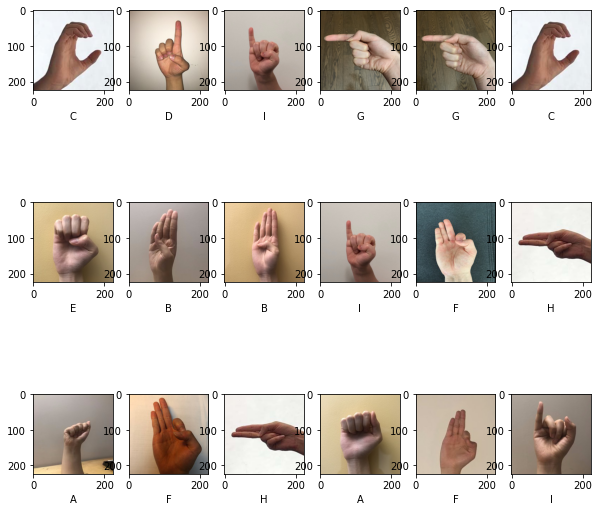

In [ ]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=transforms.ToTensor()) for x in ['train', 'val']}
val_dataloader = torch.utils.data.DataLoader(image_datasets['val'], batch_size=1, shuffle=True)
train_dataloader=torch.utils.data.DataLoader(image_datasets['train'], batch_size=1, shuffle=True)
f = plt.figure(figsize=(10, 10))
for i in range(18):
    img, label = next(iter(val_dataloader))
    img = img.squeeze().permute(1,2,0).numpy()
    plt.subplot(3,6,i+1)
    plt.imshow(img)
    plt.xlabel(class_dict[label.numpy()[0]])


# Kushagra Agarwal 2018113012

# Question 1: Model Building

In [ ]:
class ASLClassifier(nn.Module):

    def __init__(self):
        
        '''This function defines the number of layers and the number of nodes in each layer for the NN '''
        
        super(ASLClassifier, self).__init__()
        
        # Layer 1 input 224*224*3 and output is 384 nodes
        self.layer1 = nn.Linear(3 * 224 * 224, 384)
        
        # Layer 2 input 384 and output is 128 nodes
        self.layer2 = nn.Linear(384, 128)
        
        # Layer 3 input 128 and output is 64 nodes
        self.layer3 = nn.Linear(128, 64)
        
        # Layer 4 input 64 and output is 32 nodes
        self.layer4 = nn.Linear(64, 32)
        
        # Layer 5 input 32 and output is 9 nodes ( Number of classes: 0-8 )
        self.layer5 = nn.Linear(32, 9)

    def forward(self, img):
        
        '''This function defines the activation functions for the various layers in the NN
        This also computes the result from the forward propagation step '''
        
        # Converting image to a 1D Vector of dimensions 224*224*3
        flattened = img.view(-1, 3 * 224 * 224)
        
        # Relu activation
        activation1 = F.relu(self.layer1(flattened))
        
        # Relu activation
        activation2 = F.relu(self.layer2(activation1))
        
        # Relu activation
        activation3 = F.relu(self.layer3(activation2))
        
        # Relu activation
        activation4 = F.relu(self.layer4(activation3))
        
        # No activation at this layer
        output = self.layer5(activation4)
        
        return output

# Build the model accoring to specified architecture
model = ASLClassifier()

def weights_init(model):
    
    '''This function defines random initial weights to the parameters using normal distribution '''
    
    for m in model.modules():
        if isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 10)

weights_init(model)

# Question 2: Training NN

In [ ]:
def trainval(model, train_data, valid_data, device, batch_size = 20, num_iters=1, learn_rate=0.01, weight_decay=0):
    
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True) # shuffle after every epoch
    val_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.5, weight_decay=weight_decay)
    iters, losses, val_losses, train_acc, val_acc = [], [], [], [], []

    # Training
    n = 0 # The number of iterations
    for n in range(num_iters):
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            model.train() #*****************************#
            optimizer.zero_grad()         # a clean up step for PyTorch
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter

            # save the current training information
            if n%10==9:
                iters.append(n)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_accuracy = get_accuracy(model, train_data, device)
                val_accuracy = get_accuracy(model, valid_data, device)
                for im, lb in val_loader:
                    im, lb = im.to(device), lb.to(device)
                    val_out = model(im)
                    val_loss = criterion(val_out, lb)
                val_losses.append(float(val_loss)/batch_size)
                train_acc.append(train_accuracy) # compute training accuracy 
                val_acc.append(val_accuracy)   # compute validation accuracy
    print()
    # Plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Loss")
    plt.plot(iters, losses, label="Train")
    plt.plot(iters, val_losses, label="Validation")
    plt.legend(loc='best')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.subplot(1,2,2)
    plt.title("Training Accuracy")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.ylim((0,1.1))
    plt.show()
    print("Training Accuracy: {}".format(train_acc[-1]))
    print("Validation Accuracy: {}".format(val_acc[-1]))


def get_accuracy(model, data, device):
    
    '''This function computes accuracy for a given data with specifed model'''
    
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        accuracy = correct / total
        
    return accuracy

# Question 3: Overfit to a Small Dataset

## Part a)

In [ ]:
ASL_data = list(image_datasets['train'])
ASL_test = list(image_datasets['val'])

count, end_idx, cur = [0]*9, [0]*9, 0

for i in range(len(ASL_data)):
    
    label = ASL_data[i][1]

    if(label!=cur):
        
        # Printing
        print(label,":",i, end="\n")
        end_idx[label]=i
        cur=label

    count[label]+=1

# Printing
print(count)
print(end_idx)

random.seed(0)
num_train = 2
num_val = 20

ASL_train = list()
for i in range(9):
    ASL_train+= ASL_data[end_idx[i]:end_idx[i]+num_train]

ASL_val = list()
for i in range(9):
    ASL_val+= ASL_data[end_idx[i]+num_train:end_idx[i]+num_val+num_train]

# Shuffling
random.shuffle(ASL_train)
random.shuffle(ASL_val)

count1, count2 = [0]*9, [0]*9

for i in range(len(ASL_train)):
    
    label = ASL_train[i][1]
    count1[label] += 1

for i in range(len(ASL_val)):
    
    label = ASL_val[i][1]
    count2[label] += 1  

1 : 108
2 : 215
3 : 307
4 : 414
5 : 506
6 : 612
7 : 714
8 : 818
[108, 107, 92, 107, 92, 106, 102, 104, 113]
[0, 108, 215, 307, 414, 506, 612, 714, 818]


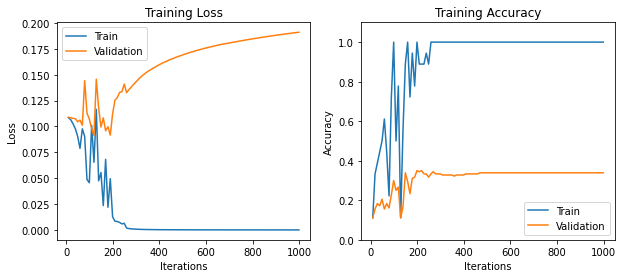

Training Accuracy: 1.0
Validation Accuracy: 0.3388888888888889


In [ ]:
model = ASLClassifier()
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
trainval(model, ASL_train, ASL_val, device, num_iters=1000)

## Part b)

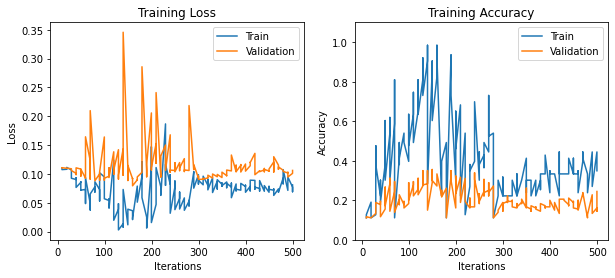

Training Accuracy: 0.3492063492063492
Validation Accuracy: 0.24444444444444444


In [ ]:
class ASLClassifierWithDropout(nn.Module):
    
    def __init__(self):
        
        '''This function defines the number of layers and the number of nodes in each layer for the NN '''
        
        super(ASLClassifierWithDropout, self).__init__()
        
        # Layer 1 input 224*224*3 and output is 384 nodes
        self.layer1 = nn.Linear(3 * 224 * 224, 384)
        
        # Layer 2 input 384 and output is 128 nodes
        self.layer2 = nn.Linear(384, 128)
        
        # Layer 3 input 128 and output is 64 nodes
        self.layer3 = nn.Linear(128, 64)
        
        # Layer 4 input 64 and output is 32 nodes
        self.layer4 = nn.Linear(64, 32)
        
        # Layer 5 input 32 and output is 9 nodes ( Number of classes: 0-8 )
        self.layer5 = nn.Linear(32, 9)

        # Applying Dropouts to the Model 
        
        # Layer 1 input has 40% Dropout 
        self.dropout1 = nn.Dropout(0.4)
        
        # Layer 2 input has 40% Dropout 
        self.dropout2 = nn.Dropout(0.4)
        
        # Layer 3 input has 40% Dropout 
        self.dropout3 = nn.Dropout(0.4)
        
        # Layer 4 input has 40% Dropout 
        self.dropout4 = nn.Dropout(0.4)

    def forward(self, img):
        
        '''This function defines the activation functions for the various layers in the NN
        This also computes the result from the forward propagation step '''
        
        # Converting image to a 1D Vector of dimensions 224*224*3
        flattened = img.view(-1, 3 * 224 * 224)
        
        # Relu activation
        activation1 = F.relu(self.layer1(flattened))
        
        # Relu activation
        activation2 = F.relu(self.layer2(activation1))
        
        # Relu activation
        activation3 = F.relu(self.layer3(activation2))
        
        # Relu activation
        activation4 = F.relu(self.layer4(activation3))
        
        # No activation at this layer
        output = self.layer5(activation4)
        
        return output

num_train_new = 1
ASL_train_new = ASL_train

for i in range(9):
    ASL_train_new += ASL_data[end_idx[i]+num_train+num_val:end_idx[i]+num_train+num_val+num_train_new]

random.shuffle(ASL_train_new)
model = ASLClassifierWithDropout()
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
trainval(model, ASL_train_new, ASL_val, device, num_iters = 500,  weight_decay = 0.005)

# Question 4: Parameter Tuning

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    
    '''This function trains the model for 25 epochs unless otherwise specified '''
    
    since = time.time()
    train_acc_history = []
    val_acc_history = []
    train_loss = []
    val_loss = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if phase=='train':
                train_acc_history.append(epoch_acc)
                train_loss.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss.append(epoch_loss)
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history,train_acc_history,train_loss,val_loss,best_acc

def set_parameter_requires_grad(model, feature_extracting):
    
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    '''This function initialises the model'''
    
    model_ft = None
    input_size = 0

    # Alexnet 
    
    # Using pretrained Alexnet to employ transfer learning 
    model_ft = models.alexnet(pretrained=use_pretrained)
    
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initializing the model
model_name = "alexnet"
feature_extract = True
num_classes = 9
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
# Expoprting the modle to GPU (if available else CPU)

model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()

# Printing learnable parameters
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
            
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print(name)

# Running Stochastic gradient descent on this
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


# Question 5: Reporting the result

In [ ]:
# As this is a classification problem we used Cross Entropy Loss function for the Loss calculation
criterion = nn.CrossEntropyLoss()
# Model training run and evaluation
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=20, shuffle=True, num_workers=4) for x in ['train', 'val']}
model_ft, val_hist,train_hist,train_loss,val_loss,best_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=30)

Epoch 0/29
----------
train Loss: 1.6283 Acc: 0.4221
val Loss: 1.0739 Acc: 0.5819

Epoch 1/29
----------
train Loss: 0.9288 Acc: 0.6402
val Loss: 0.7618 Acc: 0.6724

Epoch 2/29
----------
train Loss: 0.6850 Acc: 0.7465
val Loss: 0.6295 Acc: 0.7500

Epoch 3/29
----------
train Loss: 0.7040 Acc: 0.7379
val Loss: 0.6921 Acc: 0.7500

Epoch 4/29
----------
train Loss: 0.5640 Acc: 0.7938
val Loss: 0.5486 Acc: 0.7586

Epoch 5/29
----------
train Loss: 0.5410 Acc: 0.8131
val Loss: 0.5351 Acc: 0.7543

Epoch 6/29
----------
train Loss: 0.5362 Acc: 0.8120
val Loss: 0.5049 Acc: 0.7888

Epoch 7/29
----------
train Loss: 0.5352 Acc: 0.8045
val Loss: 0.5891 Acc: 0.7371

Epoch 8/29
----------
train Loss: 0.5458 Acc: 0.7948
val Loss: 0.5777 Acc: 0.8017

Epoch 9/29
----------
train Loss: 0.4986 Acc: 0.8088
val Loss: 0.5395 Acc: 0.7931

Epoch 10/29
----------
train Loss: 0.4765 Acc: 0.8174
val Loss: 0.4632 Acc: 0.8233

Epoch 11/29
----------
train Loss: 0.5174 Acc: 0.8088
val Loss: 0.5438 Acc: 0.7716

Ep

# Best Validation Accuracy Achieved was : **84.4828** %

### Plots for Accuracy and Losses for Training and Validation

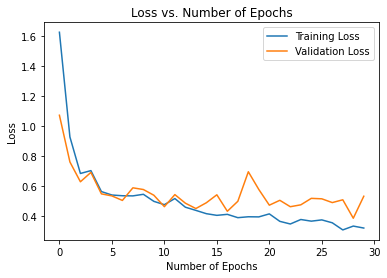

In [ ]:
plt.ylabel("Loss")
plt.xlabel("Number of Epochs")
plt.title("Loss vs. Number of Epochs")

plt.plot(range(0,30),train_loss, label = "Training Loss")
plt.plot(range(0,30),val_loss, label = "Validation Loss")

plt.legend()

plt.show()

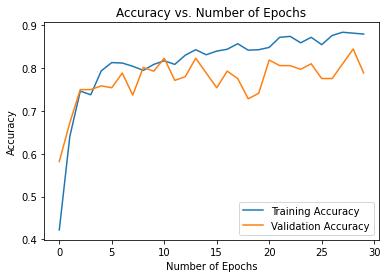

In [ ]:
plt.ylabel("Accuracy")
plt.xlabel("Number of Epochs")
plt.title("Accuracy vs. Number of Epochs")

plt.plot(range(0,30),train_hist, label = "Training Accuracy")
plt.plot(range(0,30),val_hist, label = "Validation Accuracy")

plt.legend()

plt.show()